<a href="https://colab.research.google.com/github/ragul-n/Analysis-of-Ashoka-University-Confession-page/blob/master/Topic_Modelling_using_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 

import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import matplotlib.pyplot as plt
from textblob import TextBlob


In [2]:
sentiments= pd.read_csv("/content/drive/MyDrive/au.rants.23/Datasets/sentiments.csv").drop("Unnamed: 0", axis=1)
sentiments["date"]=pd.to_datetime(sentiments["date"], yearfirst=True)
rants=list(sentiments["rant"])
sentiments.head()

,id,rant,date,positive,neutral,negative,sentiment
0,2021-08-10_18-16-37,Can someone going to campus please share how ...,2021-08-10,0.04,0.12,0.84,negative
1,2021-08-10_18-13-48,Do you guys have free mobile game recs?,2021-08-10,0.99,0.01,0.00,positive
2,2021-08-09_18-52-29,WHY ARE ALL OF US NOT COMING TO CAMPUS ?? I W...,2021-08-09,0.09,0.84,0.07,neutral
3,2021-08-07_17-20-00,I think I have feelings for my best friend an...,2021-08-07,0.98,0.00,0.02,positive
4,2021-08-09_18-53-53,"My friend's being very stupid about this guy,...",2021-08-09,0.50,0.00,0.50,mixed


### Word Cloud

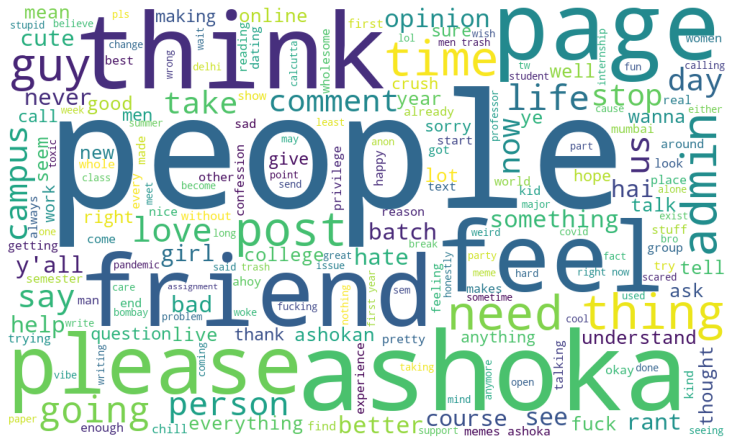

In [4]:
 from wordcloud import WordCloud, STOPWORDS


comment_words = ''
stopwords = (STOPWORDS)

stopwords = list(stopwords) + ["much", "literally","ok","many", "word", "saying", "make", "might", "really", "one", "actually", 
                               "want", "still", "keep","want", "know", "even", "entire", "go", "way", "maybe", "will", "everyone",
                               "anyone", "someone", "back"]
 
# iterate through the csv file
for val in sentiments.rant:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### LDA : Topic Modeling
Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [3]:
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(rants))

print(data_words[:1])

[['can', 'someone', 'going', 'to', 'campus', 'please', 'share', 'how', 'they', 'got', 'to', 'go', 'because', 'osa', 'has', 'been', 'ignoring', 'my', 'mails']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['can', 'someone', 'going_to', 'campus', 'please', 'share', 'how', 'they', 'got', 'to', 'go', 'because', 'osa', 'has_been', 'ignoring', 'my', 'mails']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'campus', 'share', 'get', 'go', 'osa', 'ignoring', 'mail']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=50, no_above=0.1, keep_n= None)
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [11]:
for i in lda_model.print_topics():
    print(i, end="\n\n")
doc_lda = lda_model[corpus]

(0, '0.280*"ashoka" + 0.218*"see" + 0.203*"love" + 0.172*"guy" + 0.116*"life" + 0.000*"much" + 0.000*"think" + 0.000*"make" + 0.000*"time" + 0.000*"really"')

(1, '0.506*"say" + 0.251*"talk" + 0.221*"stop" + 0.002*"much" + 0.001*"see" + 0.001*"feel" + 0.001*"time" + 0.001*"friend" + 0.001*"thing" + 0.001*"want"')

(2, '0.227*"feel" + 0.218*"want" + 0.197*"page" + 0.178*"time" + 0.172*"take" + 0.000*"much" + 0.000*"would" + 0.000*"really" + 0.000*"say" + 0.000*"thing"')

(3, '0.255*"get" + 0.226*"post" + 0.206*"even" + 0.193*"make" + 0.111*"would" + 0.000*"feel" + 0.000*"see" + 0.000*"much" + 0.000*"thing" + 0.000*"think"')

(4, '0.315*"need" + 0.298*"campus" + 0.231*"comment" + 0.138*"come" + 0.001*"would" + 0.001*"thing" + 0.001*"say" + 0.001*"really" + 0.001*"time" + 0.001*"see"')

(5, '0.265*"think" + 0.175*"really" + 0.138*"thing" + 0.114*"friend" + 0.111*"much" + 0.082*"person" + 0.076*"actually" + 0.033*"make" + 0.000*"see" + 0.000*"feel"')



In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [13]:
import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.277238 -0.020431       1        1  26.322921
2      0.208770 -0.358661       2        1  20.337670
3     -0.281578 -0.032082       3        1  19.571201
0      0.164758  0.302810       4        1  15.221999
4      0.107867  0.062397       5        1   9.875388
1      0.077421  0.045966       6        1   8.670821, topic_info=      Term        Freq       Total Category  logprob  loglift
21     say  117.000000  117.000000  Default  29.0000  29.0000
10   think  186.000000  186.000000  Default  28.0000  28.0000
1      get  132.000000  132.000000  Default  27.0000  27.0000
13  ashoka  114.000000  114.000000  Default  26.0000  26.0000
26    need   83.000000   83.000000  Default  25.0000  25.0000
..     ...         ...         ...      ...      ...      ...
14  really    0.184993  122.871967   Topic6  -7.1245  -4.0534
20    feel    0.185290  123.264552   Topic6  -7.1229  -4.0550
5     make    0.184713  123.637106   Topic6  -7.1261  -4.0611
1      get    0.184904  132.939919   Topic6  -7.1250  -4.1326
10   think    0.184598  186.061524   Topic6  -7.1267  -4.4704

[203 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        1  0.986338  actually
13        4  0.990989    ashoka
0         5  0.987667    campus
3         5  0.972526      come
4         5  0.977094   comment
7         3  0.994322      even
20        2  0.989741      feel
8         1  0.991552    friend
1         3  0.992930       get
2         4  0.981831       guy
19        4  0.981833      life
27        4  0.991148      love
5         1  0.186028      make
5         3  0.808819      make
11        1  0.987682      much
11        6  0.012663      much
26        5  0.984963      need
25        2  0.988434      page
24        1  0.982479    person
15        3  0.990203      post
14        1  0.992903    really
21        6  0.989621       say
9         4  0.988411       see
18        6  0.987230      stop
22        2  0.991724      take
16        6  0.990755      talk
17        1  0.988028     thing
10        1  0.994295     think
23        2  0.992347      time
6         2  0.995149      want
12        3  0.990588     would, R=29, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 1, 5, 2])

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

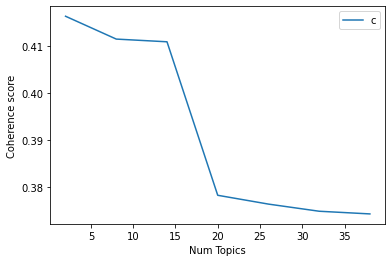

In [17]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()